In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [3]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.dpgpd import Dpgpd
from src.algorithms.adpgpd import ADpgpdExact, ADpgpdSampled
from src.sampling import Sampler

In [4]:
ds = 4
da = 2

eta = 0.01
tau = 0.2
gamma = 0.9
alpha = 1.0

epochs = 2_000
n_pe = 100
n_rho = 100_000

b = - 100

G1 = - torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, .1, 0],
    [0, 0, 0, .1]
])

R1 =  - torch.tensor([
    [1., 0],
    [0, 1.],
]).double() * (tau / 2)

G2 = - torch.tensor([
    [.1, 0, 0, 0],
    [0, .1, 0, 0],
    [0, 0, 1.0, 0],
    [0, 0, 0, 1.0]
])

R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double() * (tau / 2)

env = RobotWorld()
lqr = Lqr(env.A, env.B, gamma)
sampler = Sampler(env, gamma)

In [5]:
# Optimal
P = lqr.calculate_optimal_P(G1, R1)
K = lqr.calculate_optimal_K(R1, P)
opt_lqr = sampler.estimate_V_rho(P, 1_000_000)
opt_lqr

-569.7799011776684

In [6]:
# DPGPD
dpgpd = Dpgpd(env, eta, tau, gamma, b, G1, G2, R1, R2)
_, _, pl_exact, dl_exact = dpgpd.train_constrained(epochs, n_rho)

In [7]:
# ADPGPD
adpgpd = ADpgpdExact(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2)
_, _, pl_approx, dl_approx = adpgpd.train_constrained(epochs, n_pe, n_rho)

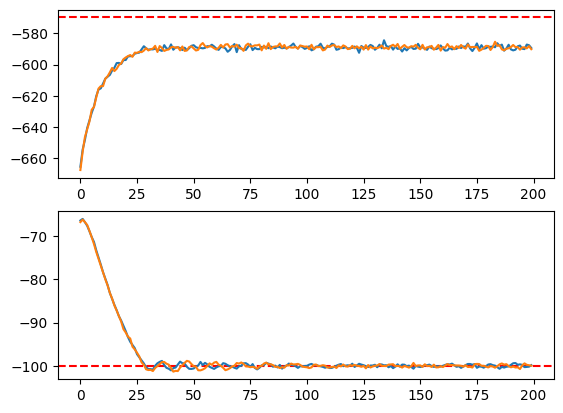

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()

axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[0].plot(pl_exact)
axes[0].plot(pl_approx)

axes[1].axhline(y=b, color='r', linestyle='--')
axes[1].plot(dl_exact)
axes[1].plot(dl_approx)

plt.show()

In [13]:
np.save('../results/vel_primal_exact.npy', pl_exact)
np.save('../results/vel_dual_exact.npy', dl_exact)
np.save('../results/vel_primal_approx.npy', pl_approx)
np.save('../results/vel_dual_approx.npy', dl_approx)